In [1]:

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats
from scipy.stats import linregress


In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='thetao',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}


In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}


In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import extract_levels
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [6]:
def prepoc1(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')
    return cube

def prepoc2(cube):
    pac_region = {"start_longitude": 140., "end_longitude": 260., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **pac_region)
    cube = axis_statistics(cube,axis='y', operator='mean')
    return cube

In [ ]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}


In [48]:
#model_nino34 = model_datasets_prep1["ACCESS-ESM1-5"].data
model_ssta = model_datasets_prep2["ACCESS-ESM1-5"].data
model_time = model_datasets_prep2["ACCESS-ESM1-5"].coord('time').points
model_lon = model_datasets_prep2["ACCESS-ESM1-5"].coord('longitude').points
model_lev = model_datasets_prep2["ACCESS-ESM1-5"].coord('depth').points

#levels = np.linspace(0, 500, 50)
#model_ssta = extract_levels(model_datasets_prep2["ACCESS-ESM1-5"], levels=levels, scheme='nearest')

#plt.contourf(model_lon, levels, model_ssta[0].data, cmap='coolwarm')
#plt.colorbar()

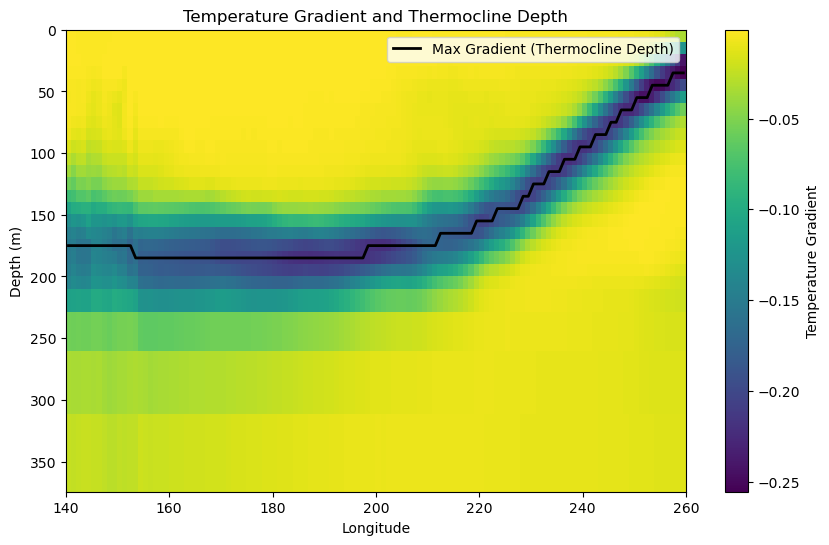

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Example temperature profile data (shape: [depth, longitude])
depth_profile = model_lev  # Depth levels (e.g., [0 to 500 meters])
temp_profile = model_ssta[0]  # Temperature profile data

# Calculate temperature gradient along the depth axis (for the first 25 depth levels)
temp_gradient = np.gradient(temp_profile[0:25, :], depth_profile[0:25], axis=0)

# Plot the temperature gradient as a contour plot
plt.figure(figsize=(10, 6))
contour_plot = plt.pcolor(model_lon, model_lev[0:25], temp_gradient, shading='auto')
plt.colorbar(label='Temperature Gradient')
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('Temperature Gradient and Thermocline Depth')

# Find the index of the absolute maximum gradient for each longitude
max_gradient_indices = np.argmax(np.abs(temp_gradient), axis=0)

# Overlay the maximum gradient line on the contour plot
thermocline_depths = model_lev[max_gradient_indices]
plt.plot(model_lon, thermocline_depths, color='black', label='Max Gradient (Thermocline Depth)', linewidth=2)

# Invert the y-axis to have depth increasing downwards
plt.gca().invert_yaxis()

plt.legend()
plt.show()


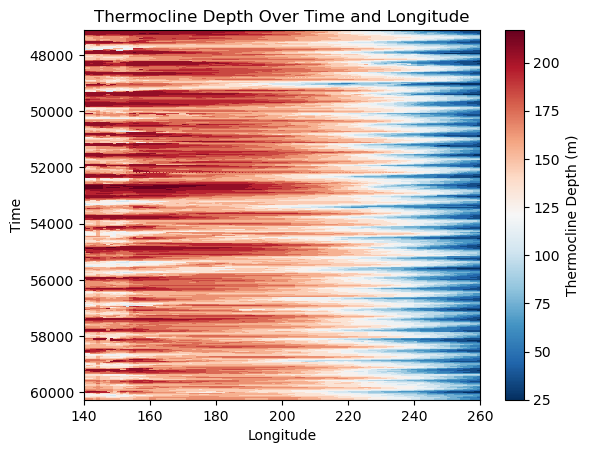

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming model_ssta has dimensions (Time, Depth, Longitude)
nTime = model_ssta.shape[0]  # Number of time steps
nDepth = model_ssta.shape[1]  # Number of depth levels
nLon = model_ssta.shape[2]  # Number of longitudes

# Initialize an array to store the thermocline depth for each time and longitude
thermocline_depths = np.zeros((nTime, nLon))

# Loop through each time step
for iTime in range(nTime):
    temp_profile = model_ssta[iTime]  # Temperature profile at this time step (shape: [Depth, Longitude])
    
    # Calculate temperature gradient along the depth axis for the first 25 depth levels
    temp_gradient = np.gradient(temp_profile[0:25, :], depth_profile[0:25], axis=0)
    
    # Find the index of the maximum absolute gradient for each longitude
    max_gradient_indices = np.argmax(np.abs(temp_gradient), axis=0)
    
    # Convert the indices to actual depths (in meters) using the depth_profile
    thermocline_depths[iTime, :] = depth_profile[max_gradient_indices]

# thermocline_depths now contains the actual depth values in meters

# Plot the thermocline depths over time and longitude
plt.pcolor(model_lon, model_time, thermocline_depths, cmap='RdBu_r', shading='auto')
plt.colorbar(label='Thermocline Depth (m)')
plt.ylabel('Time')
plt.xlabel('Longitude')
plt.title('Thermocline Depth Over Time and Longitude')
plt.gca().invert_yaxis()  # Invert the y-axis to show deeper depths downwards
